# Robust Lookup Table: Coordinates prediction

The goal of this notebook is to predict the coordinates of the backends in the output lookup table.

## TODO

- [ ] Add noise to the input
- [ ] Add dropout
- [ ] Add regularization

In [1]:
import os
import math
import datetime
import time
import uuid
import random
import hashlib

import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
from matplotlib import pyplot as plt

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [2]:
# Hyper parameters
learning_rate = 1e-3
epochs = 200
batch_size = 32

# Experiment parameters
# -- n_max: the maximum number of backends.
n_max = 5
# -- m: the size of the lookup table.
m = 15
# -- o: the number of axis for the coordinates.
o = 3
# scenario variables:
nBeforeBounds = (3, n_max)
nAfterBounds = (1, n_max)
variance = (1.0, 10)

In [3]:
# Config
# - nBeforeBounds(x, y): nBefore ∈ [x, y].
# - nAfterBounds(x, y): nAfter ∈ [x, y].
# - variance(x, y): x < min(nBefore,nAfter)/max(nBefore,nAfter); y < max(nBefore,nAfter) - min(nBefore,nAfter)
# - m: the fixed size of the lookup table.
# - o: the number of axis for coordinates.
class Config:
    n_max: int
    m: int
    o: int
    nBeforeBounds: (int, int)
    nAfterBounds: (int, int)
    variance: (float, int)

    def __init__(
        self,
        n_max: int,
        m: int,
        o: int,
        nBeforeBounds: (int, int),
        nAfterBounds: (int, int),
        variance: (float, int),
        # sizeBounds: (int, int),
    ):
        if nBeforeBounds[1] > m or nAfterBounds[1] > m:
            raise Exception("nBeforeBounds and nAfterBounds cannot exceed size")

        self.n_max = n_max
        self.m = m
        self.o = o
        self.nBeforeBounds = nBeforeBounds
        self.nAfterBounds = nAfterBounds
        self.variance = variance

Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance).__dict__

{'n_max': 5,
 'm': 15,
 'o': 3,
 'nBeforeBounds': (3, 5),
 'nAfterBounds': (1, 5),
 'variance': (1.0, 10)}

In [25]:
# m: the size of the lookup table.
# o: the number of axis for the coordinates.
# the function returns the backend coordinates of size (o,)
def NewBackendCoordinates(m: int, o: int):
    id = uuid.uuid4()
    _h = hashlib.sha256()
    _h.update(id.bytes_le)
    hash_bytes = _h.digest()

    coord = []
    hash_length = 32
    slice = int(hash_length/o)

    for i in range(o):
        start = i*slice
        end = (i+1)*slice
        if start >= hash_length:
            continue
        if end > hash_length:
            end = hash_length
        x = int.from_bytes(hash_bytes[start:end], "little") % m
        x = (x - m/2) / m
        coord.append(x)

    if len(coord) < o:
        raise Exception(f"Cannot create new backend tensor! please decrease `o`: got {o}")

    return coord

NewBackendCoordinates(m, o)

[0.03333333333333333, -0.43333333333333335, 0.1]

In [26]:
class Scenario:
    nBefore: int
    nAfter: int
    cfg: Config
    nil_coord: list

    def __init__(
        self,
        cfg: Config,
    ):
        self.cfg = cfg
        self.nBefore = random.randint(cfg.nBeforeBounds[0], cfg.nBeforeBounds[1])
        self.nAfter = random.randint(cfg.nAfterBounds[0], cfg.nAfterBounds[1])
        self.nil_coord = [ -1 for _ in range(cfg.o)]

    def GenerateBackends(self):
        l_min = []
        l_max = []
        _min = min([self.nBefore, self.nAfter])
        _max = max([self.nBefore, self.nAfter])
        # create the l_max backend array.
        l_max = np.array([ NewBackendCoordinates(self.cfg.m, self.cfg.o) for _ in range(_max) ])
        # create l_min array by randomly choosing _min elements of l_max.
        l_min = np.random.permutation(l_max)[0:_min]
        # pad
        l_max = [l_max[i] if i < _max else self.nil_coord for i in range(self.cfg.n_max) ]
        l_min = [l_min[i] if i < _min else self.nil_coord for i in range(self.cfg.n_max) ]
        # they used to be sorted but we don't need to anymore.
        if self.nBefore < self.nAfter:
            return (l_min, l_max)
        return (l_max, l_min)

def validate_scenario(cfg: Config, scenario: Scenario) -> bool:
    var = cfg.variance[0]
    delta = cfg.variance[1]

    _min = min([scenario.nBefore, scenario.nAfter])
    _max = max([scenario.nBefore, scenario.nAfter])
    _var = _min/_max
    _delta = _max - _min
    _sz = scenario.cfg.m

    return _var <= var and _delta <= delta and _max <= _sz and _min != _max

# creates a new scenario generator.
def NewScenarioGenerator(cfg):
    while True:
        scenario = Scenario(cfg)
        if validate_scenario(cfg, scenario):
            yield scenario

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scgen = next(NewScenarioGenerator(cfg))
print(scgen.__dict__)
bef, aft = scgen.GenerateBackends()
print("before:\n", bef[0])
print("after:\n", aft[0])

{'cfg': <__main__.Config object at 0x7561c25de930>, 'nBefore': 8, 'nAfter': 9, 'nil_coord': [-1, -1, -1]}
before:
 [ 0.33333333  0.46666667 -0.2       ]
after:
 [-0.2        -0.2         0.03333333]


In [27]:
# NewBatchGenerator yields a tuple of 2 batch of size batch_size.
def NewBatchGenerator(batch_size: int, scenario_generator):
    while True:
        before = []
        after = []
        for _ in range(batch_size):
            b, a = next(scenario_generator).GenerateBackends()
            before.append(b)
            after.append(a)
        yield (
            torch.tensor(np.array(before), dtype=torch.float32, requires_grad=False),
            torch.tensor(np.array(after), dtype=torch.float32, requires_grad=False),
        )

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scenario_generator = NewScenarioGenerator(cfg)
bef, aft = next(NewBatchGenerator(batch_size, scenario_generator))
print(bef[0][0:10])
print(f"tensor size must be: [{batch_size}, {cfg.n_max}, {cfg.o}]")
bef.size(), aft.size()

tensor([[-0.3000, -0.4000,  0.4667],
        [ 0.4667,  0.0333,  0.4333],
        [-0.3000,  0.4333,  0.0333],
        [-0.3000,  0.3667, -0.5000],
        [-0.3000, -0.4333, -0.3000],
        [-0.1333,  0.3667,  0.0667],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000]])
tensor size must be: [16, 9, 3]


(torch.Size([16, 9, 3]), torch.Size([16, 9, 3]))

## Loss functions

- Stability: measures how well the model predicts a lookup table that matches as much as possible entries from the "before" state.
- Accuracy: measures how precisely the model predicts coordinates. The precision is measured by calculating distance from input and output coordinates.
- Distribution: measures how evenly the model distributes coordinates into the lookup table.

In [285]:
def example_input_data():
    b = torch.tensor([
        [[0, 1, 2], [3, 4, 5], [6, 7, 8]],
        [[0, 1, 2], [-4, -4, -4], [0, 0, 0]],
    ]) 

    a = torch.tensor([
        [[0, 1, 2], [3, 4, 5], [0, 0, 0]],
        [[0, 1, 2], [-4, -4, -4], [-4, -4, -4]],
    ]) 

    return (b-4)/8, (a-4)/8

def example_output_data():
    b = torch.Tensor((
        [
            [5, 5, 5], [0, 0, 0], [1, 1, 1], [1, 1, 1],
        ],[
            [0, 0, 0], [0, 0, 0], [1, 1, 1], [1, 1, 1],
        ]
    ))
    
    a = torch.Tensor((
        [
            [0, 1, 2], [3, 4, 5], [0, 0, 0], [0, 1, 2],
        ],[
            [0, 0, 0], [0, 0, 0], [1, 1, 1], [1, 1, 1],
        ]
    ))

    b.requires_grad_(), a.requires_grad_()
    return (b-4)/8, (a-4)/8

example_b_in, example_a_in = example_input_data()
example_b_out, example_a_out = example_output_data()

# -- Stability loss experiment
d = nn.PairwiseDistance(p=2)(example_b_out, example_a_out)
print("---\npairwise distance:\n", d[0], "\nsize:\n", d.size())
d = torch.nn.Tanh()(d)
print("---\ntanh:\n", d[0])
print("---\nmean:\n", torch.mean(d))

---
pairwise distance:
 tensor([0.8839, 0.8839, 0.2165, 0.1768], grad_fn=<SelectBackward0>) 
size:
 torch.Size([2, 4])
---
tanh:
 tensor([0.7084, 0.7084, 0.2132, 0.1750], grad_fn=<SelectBackward0>)
---
mean:
 tensor(0.2256, grad_fn=<MeanBackward0>)


In [286]:
# -- stabLoss = (mean_distance / (1-max_distance))
# Stability measures how well the model predicts a lookup table that matches 
# as much as possible entries from the "before" state.
def StabilityLoss(
        # -- will help compute the baseline.
        before_in: torch.Tensor,
        after_in: torch.tensor,
        # -- will help compute the distance.
        before_out: torch.Tensor,
        after_out: torch.Tensor,
        # -- show stab
        print_stab=False,
    ):
    n_max = before_in.size(dim=1)
    m = before_out.size(dim=1)
    o = before_out.size(dim=2)
    nil_coord = torch.tensor([-1 for _ in range(o)])

    # get n for each row in batch. 
    # for each row we sum "nil" coordinates, i.e. all occurences of [-1,-1].
    before_len = n_max - torch.where(before_in == nil_coord, 1, 0).sum(dim=1)[:, 0]
    after_len = n_max - torch.where(after_in == nil_coord, 1, 0).sum(dim=1)[:, 0]

    # we calculate the maximum theoritical unchanged entry rate b/w before and after.
    # -- max_th=max(before_len, after_len)/min(before_len, after_len)
    _min = torch.where(before_len < after_len, before_len, after_len)
    _max = torch.where(before_len > after_len, before_len, after_len)
    max_th = _min/_max

    # -- compute distance b/w before_out & after_out.
    d = torch.nn.PairwiseDistance(p=2)(before_out, after_out)
    d_tanh = torch.nn.Tanh()(d)

    # stability: it accounts for maximum theoretical rate.
    # stab = computed_d/(1-max_th)
    stab = d_tanh / max_th.reshape((max_th.size(dim=0),1,1))

    if print_stab:
        print(stab)[0]
    # we return the mean over all elements of the batch.
    return torch.mean(stab)

example_b_in, example_a_in = example_input_data()
example_b_out, example_a_out = example_output_data()
StabilityLoss(example_b_in, example_a_in, example_b_out, example_a_out)

tensor(0.3384, grad_fn=<MeanBackward0>)

In [375]:
# Accuracy measures how precisely the model predicts coordinates. 
# The precision is measured by calculating distance from input and output coordinates.
#
# For each batch:
# - 1. For yi in output:
#   - 1.1. For xj in input:
#     - 1.1.1. We compute euclidian distance b/w yi & xj.
# - 2. Collect the produced vector of size [batch_size, m, n_max].
# - 3. Filter and create a vector of all minimum distances of size [batch_size, m].
# - 4. Compute the mean distance.
#
# -- x the input:  [bsz, n_max, o]
# -- y the output: [bsz, m, o]
# -- x_expand:     [bsz, m, n_max, o]
# -- y_expand:     [bsz, m, n_max, o]
# -- pdist:        [bsz, m, n_max]
# -- mdist:        [bsz, m, n_max]
# -- acc_loss = mean(mdist * pdist)
#
# NB: bsz stands for `batch_size`.
def AccuracyLoss(
        x: torch.Tensor, # the input
        y: torch.Tensor, # the output
    ):

    bsz = x.size(dim=0)
    n_max = x.size(dim=1)
    m = y.size(dim=1)
    o = y.size(dim=2)
     
    # we ensure nil coordinates are very far away
    nil_coord = torch.tensor([-1 for _ in range(o)])
    x = torch.where(x != nil_coord, x, -9999)
    
    # there are other alternatives to creates that array:
    # - x.unsqueeze(1).repeat(1, m, 1, 1) 
    # - x.unsqueeze(1).repeat_interleave(m, 1)
    # x_expand = x.unsqueeze(1).repeat_interleave(m, 1) 
    # y_expand = y.unsqueeze(2).repeat_interleave(n_max, 2) 
    x_expand = x.unsqueeze(1).expand(-1, m, -1, -1)
    y_expand = y.unsqueeze(2).expand(-1, -1, n_max, -1)

    pdist = torch.nn.PairwiseDistance(p=2)(x_expand, y_expand)
    T = 3 # it sharpens the softmin.
    mdist = F.softmin(pdist*T, dim=2)
    # The actual accuracy score:
    # z = torch.where(pdist > mdist, pdist, mdist)
    zz = (1 - mdist) / (pdist + mdist)
    # print(torch.mean(pdist / (pdist + mdist)))
    return torch.mean(mdist**2 * pdist)

# - list of distances 
# - minimum distance possible
# Accuracy 100% (1) when d = min_d. min_d / d
# Accuracy 0% (0) when d >> min_d. min_d / d
# d - min_d

example_b_in, _ = example_input_data()
example_b_out, _ = example_output_data()
acc_b=AccuracyLoss(example_b_in, example_b_out)
acc_a=AccuracyLoss(example_a_in, example_a_out)
print(acc_b)
print(acc_a)

tensor(0.0367, grad_fn=<MeanBackward0>)
tensor(0.0418, grad_fn=<MeanBackward0>)


In [241]:
# DistributionLoss measures how evenly the model distributes coordinates into the lookup table.
#
# Computation:
# - Get the mdist vector of size [bsz, m, n_max].
# - make the sum over dim=1, i.e. the distribution of each input coordinates in the output
#   lookup table.
# - Compute the target distribution as n_max/m. 
# - return the MAE or MSE.
def DistributionLoss(
        x: torch.Tensor, # the input
        y: torch.Tensor, # the output
    ):
    bsz = x.size(dim=0)
    n_max = x.size(dim=1)
    m = y.size(dim=1)
    o = y.size(dim=2)

    nil_coord = torch.tensor([-1 for _ in range(o)])
    # we compute n_tensor to compute the target distribution
    n_tensor = torch.where(x == nil_coord, 0, 1).sum(dim=1)[:,0].unsqueeze(1).expand(bsz, n_max)
    # we ensure nil coordinates are very far away
    x = torch.where(x == nil_coord, 9999, x)

    x_expand = x.unsqueeze(1).expand(-1, m, -1, -1)
    y_expand = y.unsqueeze(2).expand(-1, -1, n_max, -1)

    pdist = torch.nn.PairwiseDistance(p=2)(x_expand, y_expand)
    T = 10 # it sharpens the softmin.
    mdist = F.softmin(pdist*T, dim=2)

    distrib = torch.sum(mdist, dim=1) / m
    target_distrib =  n_tensor / m # n/m
    # return (distrib / target_distrib).mean()
    return F.mse_loss(distrib, target_distrib, reduction='sum') / 100
    
example_b_in, _ = example_input_data()
example_b_out, _ = example_output_data()
DistributionLoss(example_b_in, example_b_out)
DistributionLoss(example_a_in, example_a_out)

tensor(0.0143, grad_fn=<DivBackward0>)

## Model

In [253]:
class NN(nn.Module):
    n_max: int
    m: int
    o: int

    seq: nn.Sequential

    def __init__(
        self,
        n_max: int,
        m: int,
        o: int,
        hl_size=512, # hidden layer size
    ):
        super().__init__()
        self.n_max = n_max
        self.m = m
        self.o = o

        in_size = n_max*o
        out_size = m*o
        
        self.seq = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_size, hl_size),
            nn.ReLU(),
            nn.Linear(hl_size, hl_size),
            nn.ReLU(),
            nn.Linear(hl_size, hl_size),
            nn.ReLU(),
            nn.Linear(hl_size, out_size),
            nn.Tanh(),
        )

    # takes an input of size:    [batch_size, n_max, o]
    # returns an output of size: [batch_size, m, o]
    def forward(self, x):
        # x = nn.functional.normalize(x, dim=1) # normalize in.
        x = self.seq(x)
        x = x.view(-1, self.m, self.o) # make it 2-dimensional array.
        # return nn.functional.normalize(x, dim=1) # normalize out.
        return x

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scenario_generator = NewScenarioGenerator(cfg)
bef, _ = next(NewBatchGenerator(batch_size, scenario_generator))
model = NN(cfg.n_max, cfg.m, cfg.o, hl_size=32).to(device)
model(bef).size()

torch.Size([16, 100, 2])

## Training

model has 22024 parameters
training model...
epoch 1/300: loss=0.20186209678649902, elapsed_time=0:00:00.057341
epoch 101/300: loss=0.14205601811408997, elapsed_time=0:00:00.995022
new_lr=0.0001
epoch 201/300: loss=0.14539216458797455, elapsed_time=0:00:01.933537
epoch 300/300: loss=0.1231868714094162, elapsed_time=0:00:02.697702
b_in:
 tensor([[-0.2700,  0.2300],
        [-0.0100, -0.5000],
        [ 0.3600, -0.2200],
        [-0.2400,  0.0800],
        [-0.0300, -0.1700]])
a_in:
 tensor([[-0.0100, -0.5000],
        [-0.2700,  0.2300],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000],
        [-1.0000, -1.0000]])
b_out:
 tensor([[ 0.2613,  0.2670],
        [ 0.2328, -0.2988],
        [-0.3003, -0.2292],
        [ 0.2451, -0.2898],
        [-0.2740,  0.2518],
        [ 0.3229, -0.1656],
        [-0.3067,  0.2025],
        [ 0.3246,  0.1543],
        [-0.3433, -0.1209],
        [-0.3459,  0.0164]], grad_fn=<SliceBackward0>)
a_out:
 tensor([[ 0.2613,  0.2671],
        [ 0.2337, -0.

<function matplotlib.pyplot.show(close=None, block=None)>

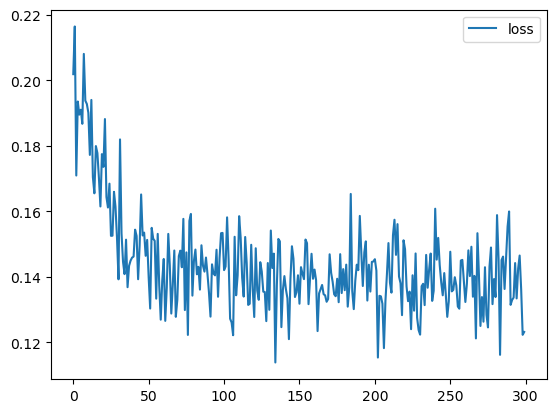

In [378]:
# Hyper parameters
learning_rate = 1e-3
epochs = 300
batch_size = 16

# Experiment parameters
# -- n_max: the maximum number of backends.
n_max = 5
# -- m: the size of the lookup table.
m = 100
# -- o: the number of axis for the coordinates.
o = 2
# -- scenario variables
nBeforeBounds = (3, n_max)
nAfterBounds = (2, n_max)
variance = (1.0, 10)
# -- hl_size: hidden layer size.
hl_size=64

cfg = Config(n_max, m, o, nBeforeBounds, nAfterBounds, variance)
scgen = NewScenarioGenerator(cfg)
batchgen = NewBatchGenerator(batch_size, scgen)

model = NN(cfg.n_max, cfg.m, cfg.o, hl_size=hl_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
print(f"model has {total_params} parameters")

start_time = time.time()
print("training model...")
loss_history = []

i = 0
for epoch in range(epochs):
    # -- reset optimizer
    optimizer.zero_grad()

    # -- generate inputs
    b_in, a_in = next(batchgen)
    # -- run model
    b_out = model(b_in)
    a_out = model(a_in)
    # -- compute loss
    loss = 0
    loss += StabilityLoss(b_in, a_in, b_out, a_out, print_stab=False)
    loss += AccuracyLoss(b_in, b_out)
    loss += AccuracyLoss(a_in, a_out)
    loss += DistributionLoss(b_in, b_out)
    loss += DistributionLoss(a_in, a_out)
    loss.backward()
    # -- step
    optimizer.step()

    # -- update learning rate
    if epoch == int((i*epochs) / 2):
        if i != 0:
            learning_rate /= 10
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            print(f"new_lr={learning_rate}")
        i += 1

    # -- display loss 
    detached_loss = loss.detach().numpy()
    loss_history.append(detached_loss)
    if epoch % 100 != 0 and epoch != epochs - 1:
        continue
    elapsed = datetime.timedelta(seconds=(time.time() - start_time))
    print(f"epoch {epoch+1}/{epochs}: loss={loss}, elapsed_time={elapsed}")

    if epoch == epochs - 1:
        print("b_in:\n", b_in[0][0:10])
        print("a_in:\n", a_in[0][0:10])
        print("b_out:\n", b_out[0][0:10])
        print("a_out:\n", a_out[0][0:10])

    # for name, param in model.named_parameters():
    #     if name == "seq.4.bias":
    #         print(f"Parameter name: {name}, data_sample: {param.data[0]}")

plt.plot(loss_history, label='loss')
plt.legend()
plt.show